# PyTorch Tutorial: Building and Training a CNN from Scratch

## Assumed Prior Knowledge
This tutorial is intended for graduate students in deep learning who have a basic background in neural networks. This tutorial assumes some knowledge about the forward and backward passes for convolutional and fully connected layers, but it is not required. You might be new to implementing full training loops or using a deep learning framework like PyTorch. No prior PyTorch experience is required, but familiarity with Python is expected. 

## Learning Outcomes 
By the end of this tutorial, you will be able to: 

1. **Work with PyTorch Tensors:** Create and manipulate tensors in PyTorch and understand how to move computations to the GPU for acceleration. 

2. **Get the gradient of a function with respect to its input:** Use PyTorch's `autograd` to compute gradients of a function with respect to its inputs.

<!-- 3. **Train a Small NN:** Create the main components of a neural network (layers, activation functions, loss functions, and optimizers) and train a simple neural network on a toy dataset.  ?? -->

2. **Build a Convolutional Neural Network (CNN):** Define a simple CNN architecture in pytorch using `torch.nn.Module`, including convolutional layers, activation functions, and fully connected layers.

3. **Train a Model End-to-End:** Implement a training loop that performs forward passes, computes loss, performs backpropagation, and updates parameters with an optimizer. You’ll also learn to monitor training progress and performance during training (e.g. tracking loss over epochs).

<!-- 4. **Handle Datasets Efficiently:** 
The main components in the pytorch framework for handling data is the `Dataset` and `DataLoader` classes. 

    1.  `torch.utils.data.Dataset` - an abstract class representing a dataset. Your custom dataset should subclass it and override `__len__` and `__getitem__`. 

    2.  `torch.utils.data.DataLoader` - wraps a dataset and provides an iterable over batches of samples. It also handles shuffling and loading data in parallel. -->

<!-- We will go through how to use these and why they are useful, but first, we will start with a subclass of `Dataset`: the `torch.utils.data.ImageFolder` which fits our data perfectly to focus on the main process of training a model. -->

5. **Modify and Experiment with the Pipeline:** Easily swap in a different dataset or change the model architecture (e.g. add more layers or dropout) with minimal code changes. You’ll also see how to adapt the same training code for a different task and my hope is that you will feel comfortable experimenting with different hyperparameters and model designs. 

6. **Evaluate and Debug Models:** Identify signs of overfitting vs. underfitting during training and apply remedies (like adjusting learning rate, changing batch size, or adding regularization). You’ll also practice saving model checkpoints and using basic logging to track experiments for debugging and improving training runs.

**Tutorial Structure:** The tutorial is split into two parts – a **45-minute interactive session** (instructor-led, with code demos and explanations) and a **hands-on task session** where you will modify and extend the provided code. This write-up covers the content of the interactive session, followed by descriptions of the tasks you’ll tackle afterward.

--- 

## Part 1: Introduction to PyTorch Tensors



### 1.1 Working with PyTorch Tensors (and GPUs)


#### 1.1.1 Similarities between `numpy.ndarray` and `torch.Tensor`
PyTorch’s core data structure is the **Tensor**, an n-dimensional array much like NumPy’s `ndarray`, with additional features such as GPU support and automatic differentiation.  
📚 [PyTorch Documentation on Tensors](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#tensors)


In [199]:
## Similarities between numpy and pytorch
import numpy as np
import torch


## numpy
print("Numpy\n------")
x = np.array([[1, 2], [3, 4]])
print(x)
print(x.dtype, x.shape)
x.sum(0)
print(x[0])
print(x[0, 0])
print(x[:, 0])
print(x == 1)

grid = np.random.randn(2, 2)
print(grid)

print()


## pytorch
print("PyTorch\n------")
x = torch.tensor([[1, 2], [3, 4]])
print(x)
print(x.dtype, x.shape)
x.sum(0)
print(x[0])
print(x[0, 0])
print(x[:, 0])
print(x == 1)

grid = torch.randn(2, 2)
print(grid)

Numpy
------
[[1 2]
 [3 4]]
int64 (2, 2)
[1 2]
1
[1 3]
[[ True False]
 [False False]]
[[ 0.29949718  1.26804985]
 [ 0.72824973 -0.03568542]]

PyTorch
------
tensor([[1, 2],
        [3, 4]])
torch.int64 torch.Size([2, 2])
tensor([1, 2])
tensor(1)
tensor([1, 3])
tensor([[ True, False],
        [False, False]])
tensor([[-0.3309,  0.7024],
        [ 0.4584,  0.8448]])


✅ Key similarities:
- Indexing and slicing syntax are identical
- Data types and shapes behave similarly
- Operations like `.sum()`, element-wise comparison, etc. feel the same

#### 1.1.2 Key differences between `numpy.ndarray` and `torch.Tensor`
| Feature | numpy.ndarray | torch.Tensor |
--- | --- | ---| 
| GPU support | ❌ CPU only | ✅ GPU or CPU |
| Automatic differentiation | ❌ Not supported | ✅ `.requires_grad` and `.backward()` |
| In-place operation safety | Not enforced | ⚠️ Can interfere with autograd |
| Integration with deep learning frameworks | ❌ | ✅ Seamless integration (nn, optim, etc.) |

<!-- 
Autograd (automatic differentiation)	❌ Not supported	✅ .requires_grad and .backward()
In-place operation safety	Not enforced	⚠️ Can interfere with autograd
Integration with deep learning frameworks	❌	✅ Seamless integration (nn, optim, etc.) -->


In [200]:
x = torch.tensor(2.0, requires_grad=True)

def f(x):
    return x**3

out = f(x)

## Compute the gradient of the output with respect to the input(s)
## Note that this needs to be a scalar or be given a vector of the same shape as the output
out.backward()

print(f"{x=}")
print(f"{f(x)=}")
print(f"{x.grad=}")

x=tensor(2., requires_grad=True)
f(x)=tensor(8., grad_fn=<PowBackward0>)
x.grad=tensor(12.)


In [202]:
# Move tensor to GPU/mac metal if available
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu")
x = x.to(device)
print(x.device)

# In-place operation caveat
a = torch.tensor([1.0, 2.0], requires_grad=True)
try:
    a += 1  ## in-place operations with grad are not allowed
except RuntimeError as e:
    print(f"RuntimeError: {e}")

mps:0
RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.


#### 1.1.3 Conversion between `numpy.ndarray` and `torch.Tensor`

In [50]:
# NumPy to PyTorch (straightforward)
x_np = np.array([[1, 2], [3, 4]])
x_torch = torch.from_numpy(x_np)
print(type(x_torch), x_torch)

# PyTorch to NumPy (not so straightforward)
x_back = x_torch.numpy()
## If requires_grad=True, then we must explicitly throw away the gradient information using detach()
x_back = x_torch.detach().numpy()
## if on the gpu as well we need to move it to the cpu first
x_back = x_torch.detach().cpu().numpy()
print(type(x_back), x_back)

<class 'torch.Tensor'> tensor([[1, 2],
        [3, 4]])
<class 'numpy.ndarray'> [[1 2]
 [3 4]]


**Memory sharing alert!:**
- `from_numpy()` creates a tensor that shares memory with the original array.
- Changes to the NumPy array will affect the tensor (and vice versa).

In [51]:
x_np[0, 0] = 999
print("Torch tensor after modifying original NumPy array:", x_torch)

Torch tensor after modifying original NumPy array: tensor([[999,   2],
        [  3,   4]])


#### 1.1.4 Gradients and Automatic Differentiation (the simple way)
PyTorch’s `autograd` package provides automatic differentiation for all operations on Tensors. It does this by keeping track of operations performed on Tensors and calculating the gradients with respect to the input. 

In the first mandatory assignment, we built a network that kept track of activations and gradients for each layer separately. In pytorch, gradients are kept track of automatically and stored in the `.grad` attribute of each tensor.

**Example:**

In [52]:
x = torch.randn(3, 3, requires_grad=True)
print(f"{x.grad=}, because it is not yet computed")
y = -0.5 * x
z = y.sum()
## backward() computes the gradient of z with respect to x
z.backward()
print(f"{x.grad=}")

x.grad=None, because it is not yet computed
x.grad=tensor([[-0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000]])


**Notice:**

`z`  is a scalar here. 
If not, we would need to provide a vector of the same shape as `z` to `backward()`, similar to the $\delta$-values in the mandatory assignment.

--- 

### 1.2 Exercises for Working with PyTorch Tensors (and GPUs)

#### Ex. 1 Memory sharing: Who's in change?

In [1]:
import numpy as np
import torch

# Step 1: Create a NumPy array and convert it to a torch tensor
arr = np.arange(9).reshape(3, 3)
tensor = torch.from_numpy(arr)

# Step 2: Modify the torch tensor
tensor[0, 0] = 999

# Step 3: Print both
print("Modified NumPy array:\n", arr)
print("Modified Tensor:\n", tensor)

Modified NumPy array:
 [[999   1   2]
 [  3   4   5]
 [  6   7   8]]
Modified Tensor:
 tensor([[999,   1,   2],
        [  3,   4,   5],
        [  6,   7,   8]])


**Questions**
1. Is the relationship symmetric?
2. How can you break this connection and make a safe copy? (Experiment with `.clone()`, `.detach()`, and `.copy()`)

---

**Okay! Now we have covered the basics of working with PyTorch tensors. Let's move on to the next section where we will build and train a simple Deep Learning model.**

## Part 2: Building and Training a Neural Network

### Overview

We’ll now walk through the full process of defining, training, and evaluating a CNN using PyTorch. We'll work step by step:
1. Datasets and Dataloaders
2. Model
3. Loss 
4. Optimizer
5. Metric (**quality measure**) to evaluate the model
6. Evaluation of the model
7. Train model (forward, backward, update parameters)
8. Evaluate model performance on test set
9. Save and load model
10. Make predictions on new data
<!-- 11. Custom dataset and dataloaders -->


### 2.1 Dataset and Dataloaders

At this point. I will just give you a dataset to start working with to get the process going. However, we will revisit datasets and dataloaders after we have trained the network. **Do not worry if the next cell is confusing, we will go through the important parts later**.

In [27]:
## MNIST Data
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

classes = list(range(10))
## Download and split the dataset into training, validation, and test sets
train_val_data = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transforms.ToTensor()
)
train_dataset, val_dataset = torch.utils.data.random_split(
    train_val_data, [50000, 10000]
)

test_dataset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transforms.ToTensor()
)

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")
## Create data loaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=64, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False
)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")


Number of training examples: 50000
Number of validation examples: 10000
Number of testing examples: 10000
Number of training batches: 782
Number of validation batches: 157
Number of testing batches: 157


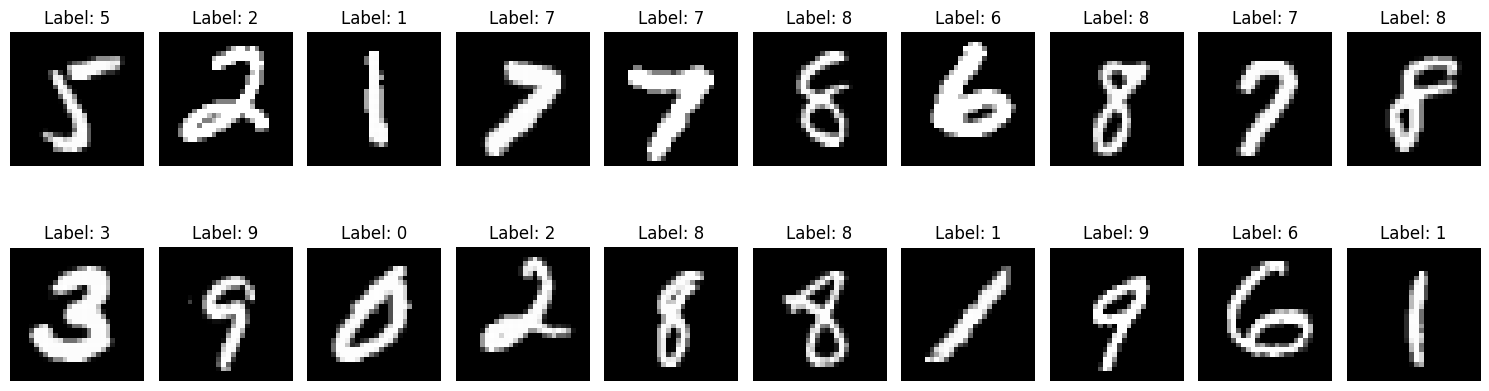

In [196]:

def plot_examples(mnist_dataset, model=None):
    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        ## Get a random image from the dataset
        idx = random.randint(0, len(mnist_dataset))
        img, label = mnist_dataset[idx]
        ax.imshow(img[0], cmap="gray")

        ## add prediction if model is provided
        if model is not None:
            ## Apply the model to the image
            pred = model(img.unsqueeze(0)).detach().numpy()
            pred_label = pred.argmax()
            ax.set_title(f"Label: {label}\nPred: {pred_label}")
        else:
            ax.set_title(f"Label: {label}")

        ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_examples(test_dataset)

In [30]:
# ## CIFAR-10 Data (similar to MNIST, but with color images), image size is 3x32x32
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import numpy as np

# ## Constants
# batch_size = 4


# ## Define the transformation to apply to the images
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(), ## Converts the image to a PyTorch tensor and scales the pixel intensity values in the range [0, 1]
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ]
# )

# ## Download (if necessary) and load the CIFAR-10 dataset
# train_val_data = torchvision.datasets.CIFAR10(
#     root="../data", train=True, download=True, transform=transform
# )

# ## Split the dataset into training and validation sets (one the model can see, the other it can't)
# train_dataset, val_dataset = torch.utils.data.random_split(train_val_data, [40000, 10000])


# train_dataloader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
# )

# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
# )

# ## Load the test set
# test_dataset = torchvision.datasets.CIFAR10(
#     root="../data", train=False, download=True, transform=transform
# )
# test_dataloader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
# )

# classes = (
#     "plane",
#     "car",
#     "bird",
#     "cat",
#     "deer",
#     "dog",
#     "frog",
#     "horse",
#     "ship",
#     "truck",
# )


# def show_cifar_batch(batch):
#     images, labels = batch
#     batch_size = len(images)
#     grid = torchvision.utils.make_grid(images, nrow=batch_size)
#     grid = grid.numpy().transpose((1, 2, 0))
#     grid = grid / 2 + 0.5
#     plt.imshow(grid)
#     plt.axis("off")
#     plt.show()
#     print(" ".join(f"{classes[labels[j]]:15s}" for j in range(batch_size)))


# # get some random training images
# dataiter = iter(train_dataloader)
# images, labels = next(dataiter)

# # show images
# show_cifar_batch((images, labels))

In [31]:
## Understand the data format
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [20]:
# ## Home made data
# from torch.utils.data import DataLoader
# from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor, Compose, Resize


# ## Preprocessing pipeline
# data_path = "/Users/hjo109/Documents/data/ForDemo"
# transform = Compose([Resize((64, 64)), ToTensor()])
# dataset = ImageFolder(root=data_path, transform=transform)

# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
#     dataset, [0.6, 0.2, 0.2]
# )

# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# print(f"Number of training batches: {len(train_dataloader)}")


# def plot_data_grid(data_loader):
#     classes = data_loader.dataset.dataset.classes
#     fig, axes = plt.subplots(3, 3)
#     axes = axes.flatten()
#     for i, (image, label) in enumerate(data_loader):
#         ax = axes[i]
#         ax.imshow(image[0].permute(1, 2, 0))
#         ax.set_title(classes[label[0].item()])
#         ax.axis("off")
#         if i == 8:
#             break
#     plt.tight_layout()
#     plt.show()


# plot_data_grid(train_dataloader)

### 2.2 Defining a Model using `nn.Module`

When subclassing `nn.Module`, we must specify one method, `forward()`, which defines the forward pass of the network. The `__init__()` method is used to define the layers of the network if that is needed. `forward()` is called when we pass data through the model as `model(data)`.

In [32]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        """Small CNN model for MNIST.

        # Assumes input images are of size (3, 32, 32).
        Assumes input images are of size (1, 28, 28).
        """
        super().__init__()
        ## Define the layers
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=32, kernel_size=5
        )
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.act2 = nn.ReLU()
        
        # self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        ## Define the forward pass
        x = self.pool(self.act1(self.conv1(x)))
        x = self.pool(self.act2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


model = CNN(in_channels=1, num_classes=10)

## try with resnet18
# import torchvision.models as models
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 10)


## If GPU is available, move model and data to GPU for faster computation, otherwise use CPU
device = torch.device(
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using device: {device}")

## Move model to device
model = model.to(device)
print(model)

Using device: mps
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [33]:
## Predict a sample image

## Get a sample image from the data loader (first batch)
image, label = next(iter(train_dataloader))
## Move image and label to device
image = image.to(device)
label = label.to(device)

## Apply the model to the image
pred = model(image)

print(image.shape)
print(pred.shape)
print(label.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])
torch.Size([64])


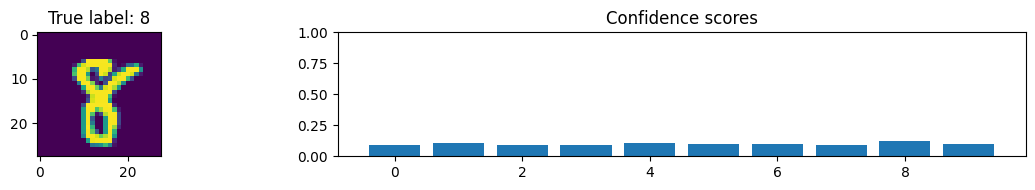

In [35]:
import matplotlib.pyplot as plt

## Show confidence scores for each class for the first sample
fig, ax = plt.subplots(1, 2, figsize=(13, 2))
ax[0].imshow(image[0].permute(1, 2, 0).cpu().numpy())
ax[0].set_title(f"True label: {classes[label[0].item()]}")
ax[1].bar(classes, pred[0].softmax(0).detach().cpu().numpy())
ax[1].set_ylim([0, 1])
ax[1].set_title("Confidence scores")
plt.tight_layout()
plt.show()

> Tip: We assume 32×32 RGB images (3 channels), and use two pooling layers, which reduce spatial dimensions to 8×8 before the fully connected layers.

### 2.3 Loss Function

Loss function (also referred to as the objective function, cost function or criterion) does 2 things:
1. Quantifies how well the model is performing. 
2. Provides a signal to the optimizer on how to update the weights.

Loss functions in PyTorch can be regular Python functions, but usually they are implemented as `nn.Module` subclasses and many of them are already implemented in `torch.nn`. Two loss functions we have seen before are the cross-entropy loss (in combination with softmax) and the mean squared error loss. We will use the cross-entropy loss in this tutorial.

In [203]:
loss_function = nn.CrossEntropyLoss()

In [208]:
def home_made_cross_entropy(pred, target):
    ## Compute the softmax of the predictions
    ## softmax
    pred = pred.exp()
    pred = pred / pred.sum(1, keepdim=True)

    ## Compute the negative log likelihood
    loss = 0
    for i in range(len(pred)):
        ## 1 * log(pred) + 0 * log(1 - pred) = log(pred) for the target class
        loss -= pred[i, target[i]].log()
    return -(pred[range(len(pred)), target].log()).mean()


print("torch version: ", loss_function(pred, label))
print("manual version: ", home_made_cross_entropy(pred, label))

torch version:  tensor(2.2967, device='mps:0', grad_fn=<NllLossBackward0>)
manual version:  tensor(2.2967, device='mps:0', grad_fn=<NegBackward0>)


### 2.4 Optimizer

In the lectures, you have seen several optimization algorithms: Gradient Descent, Stochastic Gradient Descent, Adaptable Gradient Descent (AdaGrad), Adaptive Moment Estimation (Adam), and more. 

The way the optimization algorithms are handled in PyTorch is by defining an **Optimizer** that gets 
1. `model.parameters()`: The parameters to be optimized (which all have gradients attached to them as we have seen with the tensors). If only fine tuning the head of a pre-trained model, you can pass in only the parameters of the head.
2. Hyperparameters to the optimizer such as learning rate, momentum, etc.

**Adam** and **SGD** with momentum are common default choices and usually work well, but I encourage you to experiment with different optimizers and hyperparameters to see how they affect the training.

In [210]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### 2.5 Metrics for Evaluation

To be able to tell if our model is actually doing well, we need a measure of quality of its predictions. Often, there are pairs of loss functions and metrics that do similar things, but they are usually not exactly the same. The main reason for the difference is that the loss function needs to be differentiable with respect to parameters of the model (for the optimization), while the metric does not. Therefore, the requirements for the metric are more relaxed so the __metric can be more aligned with the actual problem we are trying to solve.__

Note that in actual usage, choosing a reasonable metric is a really important parts of a deep learning system. The complexity of deep learning models make them able to model very complex relationships between inputs, but that flexibility is a blessing and a curse. The ability to model arbitrarily complex patterns also means we cannot assume the patterns aren't arbitrarily complex, making validation and interpretation hard.

Choosing the right quality measure or **metric** is crucial to understanding how well the model is performing for the purpose it is intended for.

In this tutorial we will only use one metric: **accuracy** to start with as the validation is not the main lesson here. However, I encourage you investigate different metrics for your own projects. 

<!-- 
Different metrics can give different perspectives on the performance of the model. For example, in a binary classification problem, the accuracy can be misleading if the classes are imbalanced. Eg. if one class makes up 90% of the data, a model that always predicts that class will have 90% accuracy, but still be a horrible model. 

**Metrics we will use here:**
- **Accuracy** is the most common metric for classification problems. It is the ratio of correctly predicted observations to the total observations.
- **Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations.
- **Recall** is the ratio of correctly predicted positive observations to the all observations in actual class.
- **Dice Score** is a metric used for segmentation tasks. It is the harmonic mean of precision and recall, but can also be seen as a sort of overlap measure. 


This will be used for both validation and monitoring during training. -->

In [211]:
def accuracy(soft_pred, target):
    """The number of correct predictions divided by the number of total predictions."""
    return (soft_pred.argmax(dim=1) == target).float().mean()

In [231]:
def confusion_matrix(soft_pred, target):
    """Compute the confusion matrix."""
    num_samples = soft_pred.shape[0]
    num_classes = soft_pred.shape[1]
    confusion_matrix = torch.zeros(num_classes, num_classes)
    predicted = soft_pred.argmax(1)
    for i in range(num_samples):
        confusion_matrix[target[i], predicted[i]] += 1
    return confusion_matrix

> Important: Even before training, we want to measure how good our model is *randomly initialized*. This gives us a baseline and gives us an idea of how good "as good as random" is.

### 2.6 Evaluation of the Model (baseline)

How good does our model do? Let's evaluate it on the validation set before training starts to get a baseline. 

In [234]:
def evaluate(model, dataloader):
    ## Set model to evaluation mode (important for dropout and batch normalization layers)
    model.eval()
    ## Initialize tracking variables
    loss_track = 0
    acc_track = 0

    ## Initialize confusion matrix
    con_mat_track = torch.zeros(10, 10)

    with torch.inference_mode():  ## also works with torch.no_grad(), but torch.inference_mode() is more explicit, future-proof and preferred
        for inputs, labels in dataloader:
            ## Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            ## Forward pass
            outputs = model(inputs)

            ## Compute loss
            loss = loss_function(outputs, labels)

            ## Compute metrics
            acc = accuracy(outputs, labels)
            con_mat = confusion_matrix(outputs, labels)

            ## Update statistics
            loss_track += loss.item()
            acc_track += acc
            con_mat_track += con_mat

        ## Compute average loss and accuracy
        loss_track /= len(dataloader)
        acc_track /= len(dataloader)
    return loss, acc, con_mat_track

In [235]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(cm, cmap="Blues")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(i, j, f"{cm[j, i]:.0f}", ha="center", va="center")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()

Before training: Val loss = 0.0001, Val accuracy = 1.0000
Confusion matrix:


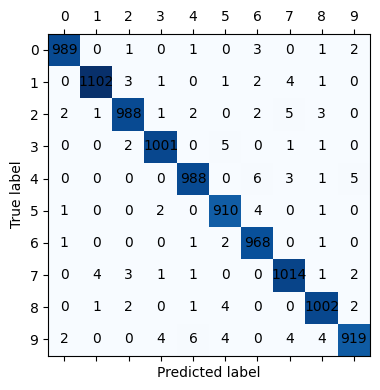

In [236]:
## Evaluate the model on the validation set
val_loss, val_acc, con_mat = evaluate(model.to(device), val_dataloader)
print(f"Before training: Val loss = {val_loss:.4f}, Val accuracy = {val_acc:.4f}")
print("Confusion matrix:")
plot_confusion_matrix(con_mat)

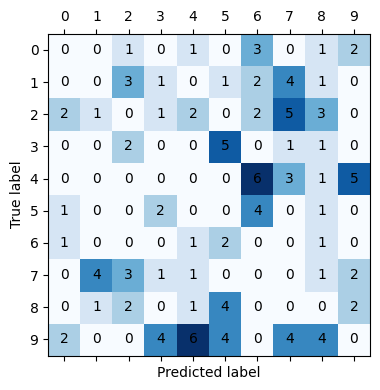

In [238]:
## What types of errors is the model making?
con_mat_non_diag = con_mat - torch.eye(10) * con_mat.diag()
plot_confusion_matrix(con_mat_non_diag)

### 2.7 Train model (forward, backward, update parameters)

In [158]:
def train_one_step(model, inputs, labels, loss_function, optimizer):
    inputs = inputs.to(device)
    labels = labels.to(device)

    ## Zero the gradients from last gradient update (otherwise they accumulate)
    optimizer.zero_grad()

    ## Forward pass
    outputs = model(inputs)

    ## Compute loss
    batch_loss = loss_function(outputs, labels)

    ## Backward pass
    batch_loss.backward()
    optimizer.step()

    ## Compute metrics
    batch_acc = accuracy(outputs, labels)
    return batch_loss, batch_acc


def train_one_epoch(model, dataloader):
    ## Set model in training mode
    model.train()

    loss = 0
    acc = 0

    for inputs, labels in dataloader:
        batch_loss, batch_acc = train_one_step(model, inputs, labels, loss_function, optimizer)
        ## Update statistics
        loss += batch_loss.item()
        acc += batch_acc

    ## Compute average loss and accuracy
    loss /= len(dataloader)
    acc /= len(dataloader)
    return loss, acc

In [162]:
x, y = next(iter(train_dataloader))
batch_loss, batch_acc = train_one_step(model, x, y, loss_function, optimizer)
print(f"Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}")

Loss: 0.0023, Accuracy: 1.0000


In [161]:
report_template = (
    "Epoch {}: Train loss = {:.4f}, val acc = {:.4f} | Val loss = {:.4f}, val acc = {:.4f}"
)
for epoch in range(1, 10):
    train_loss, train_acc = train_one_epoch(model, train_dataloader)
    val_loss, val_acc = evaluate(model, val_dataloader)

    print(report_template.format(epoch, train_loss, train_acc, val_loss, val_acc))

Epoch 1: Train loss = 0.1741, acc = 0.9462 | Val loss = 0.0081, acc = 1.0000
Epoch 2: Train loss = 0.0718, acc = 0.9773 | Val loss = 0.0049, acc = 1.0000
Epoch 3: Train loss = 0.0489, acc = 0.9845 | Val loss = 0.0132, acc = 1.0000
Epoch 4: Train loss = 0.0367, acc = 0.9883 | Val loss = 0.0326, acc = 1.0000
Epoch 5: Train loss = 0.0308, acc = 0.9901 | Val loss = 0.0035, acc = 1.0000
Epoch 6: Train loss = 0.0255, acc = 0.9917 | Val loss = 0.0018, acc = 1.0000
Epoch 7: Train loss = 0.0214, acc = 0.9933 | Val loss = 0.0010, acc = 1.0000
Epoch 8: Train loss = 0.0177, acc = 0.9946 | Val loss = 0.0038, acc = 1.0000
Epoch 9: Train loss = 0.0154, acc = 0.9949 | Val loss = 0.0057, acc = 1.0000
Epoch 10: Train loss = 0.0126, acc = 0.9960 | Val loss = 0.0163, acc = 1.0000
Epoch 11: Train loss = 0.0097, acc = 0.9967 | Val loss = 0.0013, acc = 1.0000
Epoch 12: Train loss = 0.0083, acc = 0.9973 | Val loss = 0.0016, acc = 1.0000
Epoch 13: Train loss = 0.0066, acc = 0.9984 | Val loss = 0.0099, acc = 1.

### 2.8 Evaluate model performance on test set
This is the final evaluation of the model. We have already evaluated the model on the validation set, but the test set is the final evaluation of the model. The reason we should not evaluate too much on the test set is simply to make sure we do not overfit to the test set. We want the test set to represent what you could expect the model to perform on unseen data. If you evaluate 1000 different models on the test set and pick the best one, we have essentially optimized (inefficently) on the test set and cannot expect the same performance on unseen data anymore. 

Test loss = 0.0000, Test accuracy = 1.0000


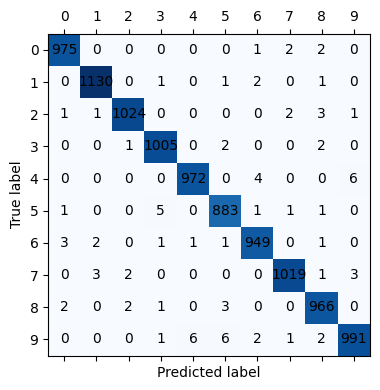

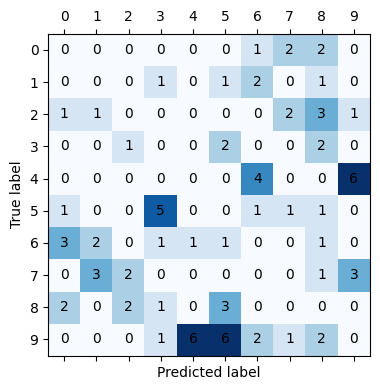

In [240]:
## Evaluate the model on the test set
test_loss, test_acc, con_mat = evaluate(model, test_dataloader)
print(f"Test loss = {test_loss:.4f}, Test accuracy = {test_acc:.4f}")
plot_confusion_matrix(con_mat)
plot_confusion_matrix(con_mat - torch.eye(10) * con_mat.diag())


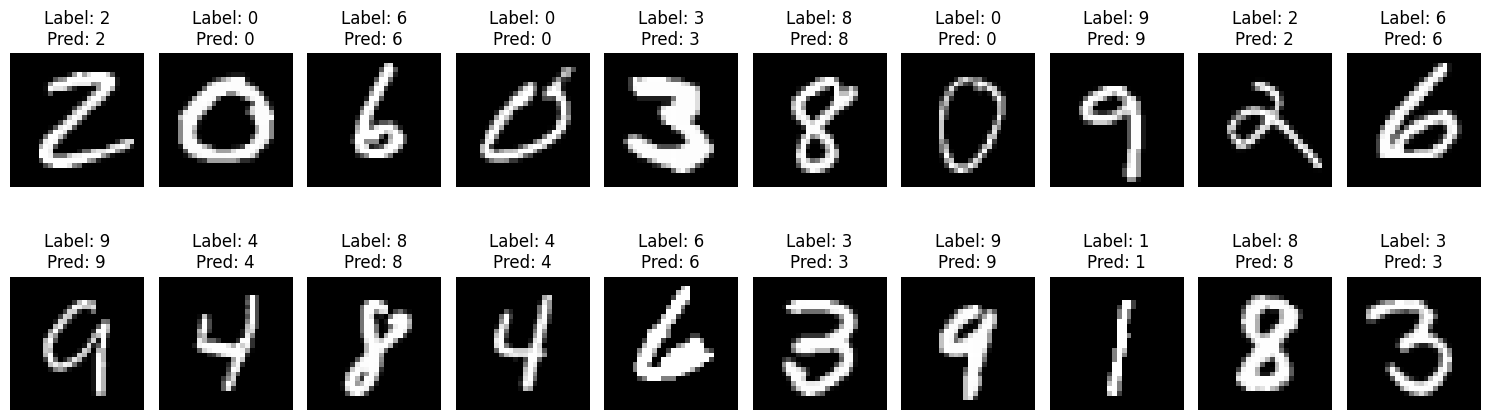

In [241]:
plot_examples(test_dataset, model=model.to("cpu"))

### 2.9 Save and load model

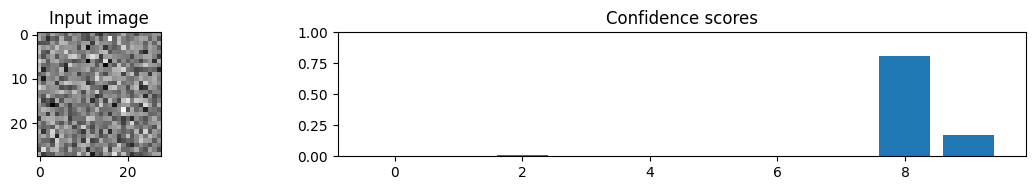

In [247]:
## save model
torch.save(model.state_dict(), "model.pth")

## or save onnx (Open Neural Network Exchange)
dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(model, dummy_input, "model.onnx")

## load model
model = CNN(in_channels=1, num_classes=10)
model.load_state_dict(torch.load("model.pth"))


## Inference with PyTorch model
model.eval()
torch_outs = model(dummy_input)

## plot image with prediction confidence scores
fig, ax = plt.subplots(1, 2, figsize=(13, 2))
ax[0].imshow(dummy_input[0, 0].detach().numpy(), cmap="gray")
ax[0].set_title("Input image")
ax[1].bar(classes, torch_outs[0].softmax(0).detach().numpy())
ax[1].set_ylim([0, 1])
ax[1].set_title("Confidence scores")
plt.tight_layout()
plt.show()



### 2.10 Diagnosing and Fixing Problems

During training, it's common to encounter issues that show up in your training and validation loss or accuracy curves. 
- If the **training loss decreases but validation loss increases**, you're likely **overfitting** — try reducing model capacity (size), adding **dropout**, using **weight decay (L2 regularization)**, or applying **data augmentation**. 
- If **both training and validation loss stay high**, your model may be **underfitting** — try a **larger model**, **train longer**, or reduce the **learning rate**. 
- If the loss **fluctuates heavily** or fails to improve, your **learning rate may be too high** - try lowering it. 
- If training is **very slow** or the loss decreases only marginally, the **learning rate may be too low**. 
- Also consider whether your **model is too small for the task**, or your **batch size is too small**, which can make **optimization noisy**. 

**Always monitor both loss and metrics on training and validation sets — they’re your most reliable tools for diagnosing training behavior!**


### Part 2.11: Custom Dataset

Making custom datasets is relatively easy in PyTorch. You need to subclass `torch.utils.data.Dataset` and implement `__len__` and `__getitem__`.

- `__len__` returns the size of the dataset and is the method that is called when running `len(dataset)`.
- `__getitem__` is used to retrieve a sample from the dataset at a given index such as `dataset[0]`.

See the example below:

In [ ]:
## Example
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, data_arg=None):
        super().__init__()
        self.n_data_points = 100
        self.data_arg = data_arg

    def __len__(self):
        return self.n_data_points
    
    def __getitem__(self, idx):
        dummy_input_data = torch.randn(1, 28, 28)
        dummy_label = torch.randint(0, 10, (1,))
        return dummy_input_data, dummy_label


dataset = CustomDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

for inputs, labels in dataloader:
    print(inputs.shape, labels.shape)
    break

## Part 3: Modify and Experiment with the Pipeline



## Part 4: Hands-On Tasks



Now we have some tasks for you to use what we have covered. In the lab session, you will be given the same code illustrated above (for data loading, model definition, and training loop). Your tasks is to make intentional modifications and observing the effects. Here are the specific exercises: 

1. **Swap the Dataset:** Using the provided code, train the CNN on a different image dataset. You can use a built-in dataset like CIFAR-10, MNIST, or FashionMNIST. This exercise will help you understand how to swap datasets in PyTorch and observe how the model performs on different data distributions.

2. **Modify the Model Architecture:** Increase the complexity of the model and observe the impact. For instance, add an additional convolutional layer (making it three conv layers in total), or increase the number of neurons in the fully connected layers, or insert a `nn.Dropout` layer after `conv2` or between the FC layers. Train the modified model for a few epochs. Does it achieve lower training loss or higher accuracy? Also watch if it overfits more quickly due to increased capacity. This exercise reinforces how to iterate on model design in PyTorch. 

3. **Tweak Training Hyperparameters:** Experiment with the training loop settings. Try a higher learning rate (e.g. 0.01 instead of 0.001) and see if the model converges faster or if it becomes unstable. Alternatively, change the batch size (e.g. 64 or 128 instead of 32) – note how that affects the training speed per epoch and the stability of updates. You can also enable weight decay in the optimizer (e.g. `optim.SGD(..., weight_decay=1e-4)`) as a form of L2 regularization to combat overfitting. The purpose here is to develop intuition on how hyperparameters like learning rate and batch size influence training dynamics. 

4. **Convert to an Autoencoder (Advanced Challenge):** An autoencoder is a network trained to reconstruct its input as we have seen in the lectures. Try modifying the CNN architecture into an autoencoder. For example, use the current CNN as an **encoder** (downsampling image to a feature vector), then add a **decoder** that mirrors it (up-sampling back to the original image size using transpose convolutions or interpolation). Train the autoencoder on a dataset of images where the “labels” are the inputs themselves.

5. **Implement Basic Logging:** As you experiment with the above tasks, practice logging the outcomes. For each experiment (dataset swap, architecture change, etc.), record the training and validation loss/accuracy. You can simply print them or use TensorBoard / Wandb for a cleaner visualization. For example, if you try three different learning rates, you can plot three training curves to compare which one converges fastest or leads to the best validation performance. This logging habit will help you debug issues (like spotting divergence early) and is very important in real-world deep learning projects where you might try lots of experiments. 


## Summary
In this tutorial, we have discussed the basics of working with PyTorch tensors, including moving computations to the GPU, getting gradients with `autograd`, and converting between NumPy arrays and PyTorch tensors. 

We then built and trained a simple CNN from scratch, covering the key components of a deep learning pipeline: 
- datasets
- model architecture
- loss functions
- optimizers
- evaluation metrics. 

We also discussed how to diagnose and fix common training issues, and how to experiment with different hyperparameters and model architectures. Finally, we outlined a series of tasks for you to practice modifying and extending the workflow on your own.